# 范例2. 使用HOG、滑动视窗、影像金字塔及SVM进行物件侦测

In [3]:
# 载入套件
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

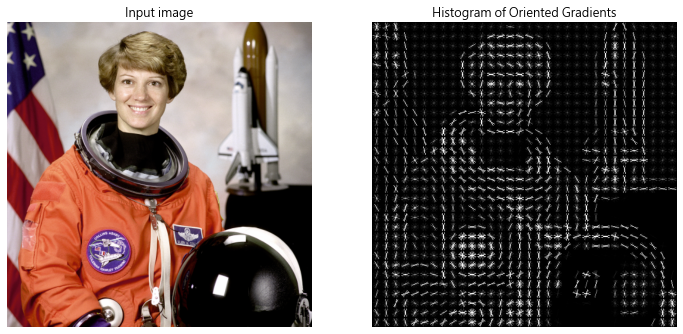

In [4]:
# 测试图片
image = data.astronaut()

# 取得图片的 hog
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

# 原图与 hog图比较 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# 调整对比，让显示比较清楚
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [5]:
# 收集正样本 (positive set)
# 使用 scikit-learn 的人脸资料集
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape 

(13233, 62, 47)

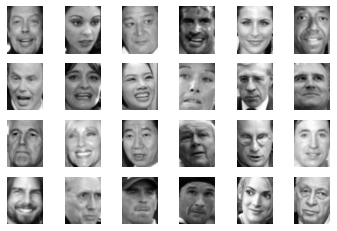

In [6]:
# 显示正样本部份图片
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[500 * i], cmap='gray')
    axi.axis('off')

In [10]:
# 收集负样本 (negative set)
# 使用 Scikit-Image 的非人脸资料
from skimage import data, transform, color

imgs_to_use = ['hubble_deep_field', 'text', 'coins', 'moon',
               'page', 'clock','coffee','chelsea','horse']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]
len(images)

9

In [11]:
# 将负样本转换为不同的尺寸
from sklearn.feature_extraction.image import PatchExtractor

# 转换为不同的尺寸
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    # PatchExtractor：产生不同尺寸的图像
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

# 产生 27000 笔图像
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape 

(27000, 62, 47)

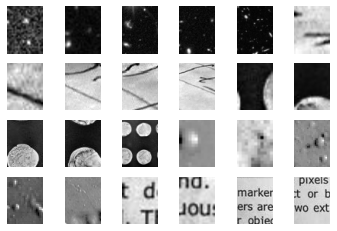

In [12]:
# 显示部份负样本
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[600 * i], cmap='gray')
    axi.axis('off')

In [13]:
# 合并正样本与负样本
from skimage import feature   # To use skimage.feature.hog()
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [14]:
# 使用 SVM 作二分类的训练
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

# C为矫正过度拟合强度的倒数，使用 GridSearchCV 寻求最佳参数值
grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.987721522133572

In [15]:
# 取得最佳参数值
grid.best_params_ 

{'C': 1.0}

In [16]:
# 依最佳参数值再训练一次
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(dual=False)

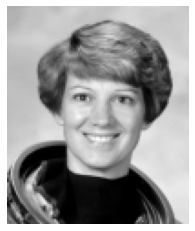

In [17]:
# 取新图像测试
test_img = data.astronaut()
test_img = color.rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:120, 60:160]


plt.imshow(test_img, cmap='gray')
plt.axis('off');

In [18]:
# 滑动视窗函数
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [22]:
# 使用滑动视窗计算每一视窗的 Hog
indices, patches = zip(*sliding_window(test_img))
patches_hog = np.array([feature.hog(patch) for patch in patches])

# 辨识每一视窗
labels = model.predict(patches_hog)
labels.sum() # 侦测到的总数

55.0

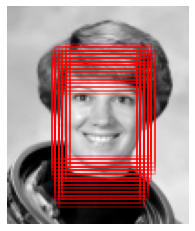

In [23]:
# 将每一个侦测到的视窗显示出来
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

# 取得左上角座标
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

# 显示
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

In [29]:
patches_hog.shape

(551, 1215)

In [30]:
candidate_patches = patches_hog[labels == 1]
candidate_patches.shape

(55, 1215)

##  Non-Maximum Suppression演算法
#### https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

In [41]:
# Non-Maximum Suppression演算法 by Felzenszwalb et al.
# boxes：所有候选的视窗，overlapThresh：视窗重叠的比例门槛
def non_max_suppression_slow(boxes, overlapThresh=0.5):
    if len(boxes) == 0:
        return []
    
    pick = []        # 储存筛选的结果
    x1 = boxes[:,0]  # 取得候选的视窗的左/上/右/下 座标
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    # 计算候选视窗的面积
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)   # 依视窗的底Y座标排序
    
    # 比对重叠比例
    while len(idxs) > 0:
        # 最后一笔
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # 比对最后一笔与其他视窗重叠的比例
        for pos in range(0, last):
            j = idxs[pos]
            
            # 取得所有视窗的涵盖范围
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            
            # 计算重叠比例
            overlap = float(w * h) / area[j]
            
            # 如果大于门槛值，则储存起来
            if overlap > overlapThresh:
                suppress.append(pos)
                
        # 删除合格的视窗，继续比对
        idxs = np.delete(idxs, suppress)
        
    # 传回合格的视窗
    return boxes[pick]

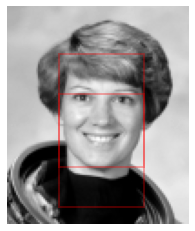

In [45]:
# 使用 Non-Maximum Suppression演算法，剔除多余的视窗。
candidate_boxes = []
for i, j in indices[labels == 1]:
    candidate_boxes.append([j, i, Nj, Ni])
final_boxes = non_max_suppression_slow(np.array(candidate_boxes).reshape(-1, 4))

# 将每一个合格的视窗显示出来
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

# 显示
for i, j, Ni, Nj in final_boxes:
    ax.add_patch(plt.Rectangle((i, j), Ni, Nj, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))